In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

/Users/hyunsuk/.pyenv/versions/3.9.1/envs/ds/lib/python3.9/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
connection = psycopg2.connect(host='localhost', dbname='coin',user='hyunsuk',password='fun309',port=5432)
cursor = connection.cursor()

In [4]:
sql = """
    SELECT *
    FROM candles
"""
cursor.execute(sql)
df = pd.DataFrame(cursor.fetchall(), columns = ['market', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'value'])
df.set_index('datetime', inplace=True)

In [5]:
df.head()

,market,open,high,low,close,volume,value
datetime,,,,,,,
2021-10-23 07:20:00,KRW-ETH,4871000.0,4873000.0,4871000.0,4872000.0,12.141957,5.915359e+07
2021-10-23 07:21:00,KRW-ETH,4873000.0,4879000.0,4873000.0,4877000.0,13.249580,6.458540e+07
2021-10-23 07:22:00,KRW-ETH,4876000.0,4879000.0,4874000.0,4876000.0,73.690283,3.592870e+08
2021-10-23 07:23:00,KRW-ETH,4876000.0,4878000.0,4874000.0,4875000.0,22.151015,1.079877e+08
2021-10-23 07:24:00,KRW-ETH,4878000.0,4880000.0,4875000.0,4878000.0,23.535639,1.148077e+08


In [6]:
def get_stochastic_fast_k(close_price, low, high, n=5):
    fast_k = ((close_price - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return fast_k

# Slow %K = Fast %K의 m기간 이동평균(SMA)
def get_stochastic_slow_k(fast_k, n=3):
    slow_k = fast_k.rolling(n).mean()
    return slow_k

# Slow %D = Slow %K의 t기간 이동평균(SMA)
def get_stochastic_slow_d(slow_k, n=3):
    slow_d = slow_k.rolling(n).mean()
    return slow_d

def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

def get_rsi(price, period=14):
    delta = price.diff()
    gains, declines = delta.copy(), delta.copy()
    gains[gains < 0] = 0
    declines[declines > 0] = 0
    
    _gain = gains.ewm(com=(period-1), min_periods=period).mean()
    _loss = declines.abs().ewm(com=(period-1), min_periods=period).mean()
    RS = _gain / _loss
    
    return pd.Series(100 - (100/(1+RS)), name = 'RSI')


## MA: 이동평균선
df['MA5'] = df['close'].rolling(window=5).mean()
df['MA20'] = df['close'].rolling(window=20).mean()
df['MA60'] = df['close'].rolling(window=60).mean()
# df['MA200'] = df['Close'].rolling(window=200).mean()

df['stddev'] = df['close'].rolling(window=20).std() # 20일 이동표준편차
df['upper'] = df['MA20'] + 2*df['stddev'] # 상단밴드
df['lower'] = df['MA20'] - 2*df['stddev'] # 하단밴드
df['upper-lower'] = df['upper']-df['lower']

df['MA20-MA5'] = df['MA20'] - df['MA5']
df['MA60-MA20'] = df['MA60'] - df['MA20']

# MACD
macd_short, macd_long, macd_signal=12,26,9 #기본값
df["MACD_short"]=df['close'].ewm(span=macd_short).mean()
df["MACD_long"]=df['close'].ewm(span=macd_long).mean()
df["MACD"]=df.apply(lambda x: (x["MACD_short"]-x["MACD_long"]), axis=1)
df["MACD_signal"]=df["MACD"].ewm(span=macd_signal).mean()  
df["MACD_oscillator"]=df.apply(lambda x:(x["MACD"]-x["MACD_signal"]), axis=1)
df["MACD_sign"]=df.apply(lambda x: ("매수" if x["MACD"]>x["MACD_signal"] else "매도"), axis=1)


# fast_k, slow_k, slow_d를 획득
df['fast_k5'] = get_stochastic_fast_k(df['close'], df['low'], df['high'], 5)
df['slow_k3'] = get_stochastic_slow_k(df['fast_k5'], 3)
df['slow_d3'] = get_stochastic_slow_d(df['slow_k3'], 3)

df['fast_k10'] = get_stochastic_fast_k(df['close'], df['low'], df['high'], 10)
df['slow_k6'] = get_stochastic_slow_k(df['fast_k10'], 6)
df['slow_d6'] = get_stochastic_slow_d(df['slow_k6'], 6)

df['fast_k20'] = get_stochastic_fast_k(df['close'], df['low'], df['high'], 20)
df['slow_k12'] = get_stochastic_slow_k(df['fast_k20'], 12)
df['slow_d12'] = get_stochastic_slow_d(df['slow_k12'], 12)


# RSI
df['rsi'] = get_rsi(df['close'])

In [7]:
df.head()

,market,open,high,low,close,volume,value,MA5,MA20,MA60,...,fast_k5,slow_k3,slow_d3,fast_k10,slow_k6,slow_d6,fast_k20,slow_k12,slow_d12,rsi
datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-23 07:20:00,KRW-ETH,4871000.0,4873000.0,4871000.0,4872000.0,12.141957,5.915359e+07,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-23 07:21:00,KRW-ETH,4873000.0,4879000.0,4873000.0,4877000.0,13.249580,6.458540e+07,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-23 07:22:00,KRW-ETH,4876000.0,4879000.0,4874000.0,4876000.0,73.690283,3.592870e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-23 07:23:00,KRW-ETH,4876000.0,4878000.0,4874000.0,4875000.0,22.151015,1.079877e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-23 07:24:00,KRW-ETH,4878000.0,4880000.0,4875000.0,4878000.0,23.535639,1.148077e+08,4875600.0,NaN,NaN,...,77.777778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'earn+20 size')

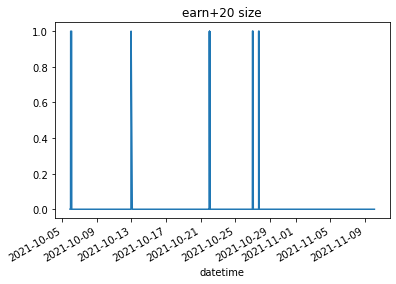

In [15]:
df['close_t+20'] = df['close'].shift(-20)
df['close_t+60'] = df['close'].shift(-60)
df['close_t+120'] = df['close'].shift(-120)

df['earn+20'] = (1.05*df['close'] < df['close_t+20']).astype(int)
df['earn+60'] = (1.05*df['close'] < df['close_t+60']).astype(int)
df['earn+120'] = (1.05*df['close'] < df['close_t+120']).astype(int)

df['earn+120'].plot()
plt.title('earn+20 size')

In [16]:
#t-1의 값을 Feature로 사용하기 위함

features = [
    'close', 'open', 'high', 'low', 'volume', 'MA5', 'MA20', 'MA60', 
    'MA60-MA20', 'MA20-MA5', 'MACD', 'MACD_oscillator', 
    'MACD_signal', 'fast_k5', 'slow_k3', 'slow_d3', 'fast_k10', 'slow_k6', 'slow_d6', 
    'fast_k20', 'slow_k12', 'slow_d12', 'rsi', 'upper', 'lower', 'stddev', 'upper-lower'
]

for feature in features:
    df[feature+'-1']=df[feature].shift(1)

In [17]:
df_na = df.dropna()
print('Total: {}'.format(len(df_na)))
print('5% up: {}'.format(len(df_na[df['earn+120']==1])))


Total: 50217
5% up: 244


<ipython-input-17-8429ad8a80bb>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('5% up: {}'.format(len(df_na[df['earn+120']==1])))


In [18]:
features = [
    'volume-1', 'MA20-MA5-1', 'MA60-MA20-1', 'MACD-1', 'MACD_oscillator-1', 
    'MACD_signal-1', 'slow_k3-1', 'slow_d3-1', 'slow_k6-1', 'slow_d6-1', 
    'slow_k12-1', 'slow_d12-1', 'rsi-1', 'upper-1', 'lower-1', 'stddev-1', 'upper-lower-1'
]

target = df_na['earn+120']

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_na[features], target, test_size=0.25, random_state=123456)


In [21]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

/Users/hyunsuk/.pyenv/versions/3.9.1/envs/ds/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(oob_score=True, random_state=123456)

In [22]:
from sklearn.metrics import accuracy_score

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')


Out-of-bag score estimate: 0.998
Mean accuracy score: 0.998


In [24]:
df_loss = df.loc[y_test[(y_test!=predicted) & (predicted==1)].index]
print('avg: {}'.format((df_loss['close_t+120'] - df_loss['close']).mean()))
print('min: {}'.format((df_loss['close_t+120'] - df_loss['close']).min()))
print('max: {}'.format((df_loss['close_t+120'] - df_loss['close']).max()))


avg: nan
min: nan
max: nan


### - Grid Search 너무 느림

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [55]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

In [ ]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()
